# Run MCMC for JIMWLK

In [1]:
from src import workdir, parse_model_parameter_file
from src.emulator_BAND import EmulatorBAND
from src.mcmc import Chain

import dill
import os
import pickle

In [2]:
exp_path = "./exp_data_JIMWLK.pkl"
model_par = "./IP_DIFF_JIMWLK_prior_range_delete_unused"
mymcmc = Chain(expdata_path=exp_path, model_parafile=model_par)


[INFO][mcmc] Initializing MCMC ...
[INFO][mcmc] Final Markov Chain results will be saved in mcmc/chain.pkl
[INFO][mcmc] Loading the model parameters space from ./IP_DIFF_JIMWLK_prior_range_delete_unused ...
[INFO][mcmc] Run MCMC with emcee...
[INFO][mcmc] Loading the experiment data from ./exp_data_JIMWLK.pkl ...
[INFO][mcmc] Experimental dataset size: 73


In [3]:
emuPathList = ["./emulator.pkl"]
mymcmc.loadEmulator(emuPathList)

[INFO][mcmc] Number of Emulators: 1


In [4]:
os.environ["OMP_NUM_THREADS"] = "1"
# may have to: export RDMAV_FORK_SAFE=1 before running the code
n_effective=800
n_active=400
n_prior=160
sample="tpcn"
n_max_steps=100
random_state=42

n_total = 1000
n_evidence = 1000


pool = 12

sampler = mymcmc.run_pocoMC(n_effective=n_effective, n_active=n_active,
                            n_prior=n_prior, sample=sample,
                            n_max_steps=n_max_steps, random_state=random_state,
                            n_total=n_total, n_evidence=n_evidence, pool=pool)

[INFO][mcmc] Generate the prior class for pocoMC ...
[INFO][mcmc] Starting pocoMC ...


Iter: 2it [00:00,  1.73it/s, beta=0, calls=400, ESS=399, logZ=0, logP=-3.2e+299, acc=1, steps=1, eff=1]/usr/local/lib/python3.10/dist-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/usr/local/lib/python3.10/dist-packages/torch/cuda/__init__.py:749: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() if nvml_count < 0 else nvml_count
Iter: 17it [02:14,  7.91s/it, beta=1, calls=35800, ESS=1241, logZ=-372, logP=-371, acc=0.202, steps=5, eff=0.895]          

[INFO][mcmc] Generate the posterior samples ...
[INFO][mcmc] Generate the evidence ...
Log evidence:  -370.6253393039317
Log evidence error:  0.34912811817844563
[INFO][mcmc] Writing pocoMC chains to file...


In [5]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams.update({'font.size': 15})

In [6]:
PARAMETER_NAMES = [
    r'$m\;[\mathrm{GeV}]$',
    r'$B_G\;[\mathrm{GeV}^{-2}]$',
    r'$B_{G,{\rm q}}\;[\mathrm{GeV}^{-2}]$',
    r'$\sigma$',
    r'$N_{\rm q}$',
    r'$Q_{s}/\mu$',
    r'$m_{\rm JIMWLK}$',
    r'$\Lambda_{\rm QCD}$'
    ]

prior_ranges = [
    (0.05,3),
    (1,10),
    (0.1,3),
    (0,1.5),
    (1,10),
    (0.2,1.5),
    (0.05,3),
    (0.001,0.2)
] 

def read_pkl_file_chain_pocoMC(PATH_pklfile_chains):
    """
    data is a dictionary containing:
    - 'chain'
    - 'weights'
    - 'logl'
    - 'logp'
    - 'logz'
    - 'logz_err'
    """
    with open(PATH_pklfile_chains, 'rb') as pf:
        data = pickle.load(pf)

    return data

In [7]:
def plot_corner_1dataset(n_parameters,data_array,filename,real_parameters=None):
    # check the dimension of the data array
    dim = len(data_array.shape)
    if dim == 3:
        samples = data_array[:,:,:].reshape((-1,n_parameters))
    elif dim == 2:
        samples = data_array[:,:].reshape((-1,n_parameters))
    else:
        raise ValueError("The data array should have 2 or 3 dimensions")

    # Create subplots
    fig, axes = plt.subplots(n_parameters, n_parameters, figsize=(25, 25), sharex='col', sharey='row')

    # Loop over each parameter pair
    for i in range(n_parameters):
        for j in range(n_parameters):
            ax = axes[i, j]

            if i == j:
                ax = fig.add_subplot(n_parameters, n_parameters, i * n_parameters + j + 1)
                ax.hist(samples[:, i], bins=20, color='g', histtype='step', density=True)
                ax.set_yticks([])
                ax.set_yticklabels([])
                if i != n_parameters-1:
                    ax.set_xticks([])
                    ax.set_xticklabels([])
                if i == n_parameters-1:
                    ax.tick_params(axis='x', rotation=45, labelsize=10)

                # Calculate percentiles
                percentiles = np.percentile(samples[:, i], [16, 50, 84])
                median = percentiles[1]
                upper = percentiles[2] - median
                lower = median - percentiles[0]

                ax.annotate(fr'${median:.2f}_{{-{lower:.2f}}}^{{+{upper:.2f}}}$', xy=(0.5, 1.05), xycoords='axes fraction', ha='center')

                # Add a vertical line representing the real value
                if real_parameters is not None:
                    real_value = real_parameters[i]
                    ax.axvline(x=real_value, color='k', linestyle='-')

                ax.set_xlim([prior_ranges[i][0], prior_ranges[i][1]])
            # Only fill the lower triangle
            if i > j:
                ax.hist2d(samples[:, j], samples[:, i], bins=20, cmap='Greens')


            # Set labels on the lowest and leftmost plots
            if i == n_parameters - 1:
                ax.set_xlabel(PARAMETER_NAMES[j])
            if j == 0:
                ax.set_ylabel(PARAMETER_NAMES[i])

            if i < j:
                ax.axis('off')

    # Remove space between subplots
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)

    # Remove ticks and labels for the first and last plots
    axes[0, 0].tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
    axes[n_parameters - 1, n_parameters - 1].tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)

    # Rotate x-axis tick labels
    for ax in axes[-1]:
        ax.tick_params(axis='x', rotation=45, labelsize=10)

    # Rotate y-axis tick labels
    for ax in axes[:, 0]:
        ax.tick_params(axis='y', rotation=45, labelsize=10)

    plt.savefig(f"{filename}.pdf")

In [8]:
PATH_pklfile = './mcmc/chain.pkl'
RUN1_DATA = read_pkl_file_chain_pocoMC(PATH_pklfile)

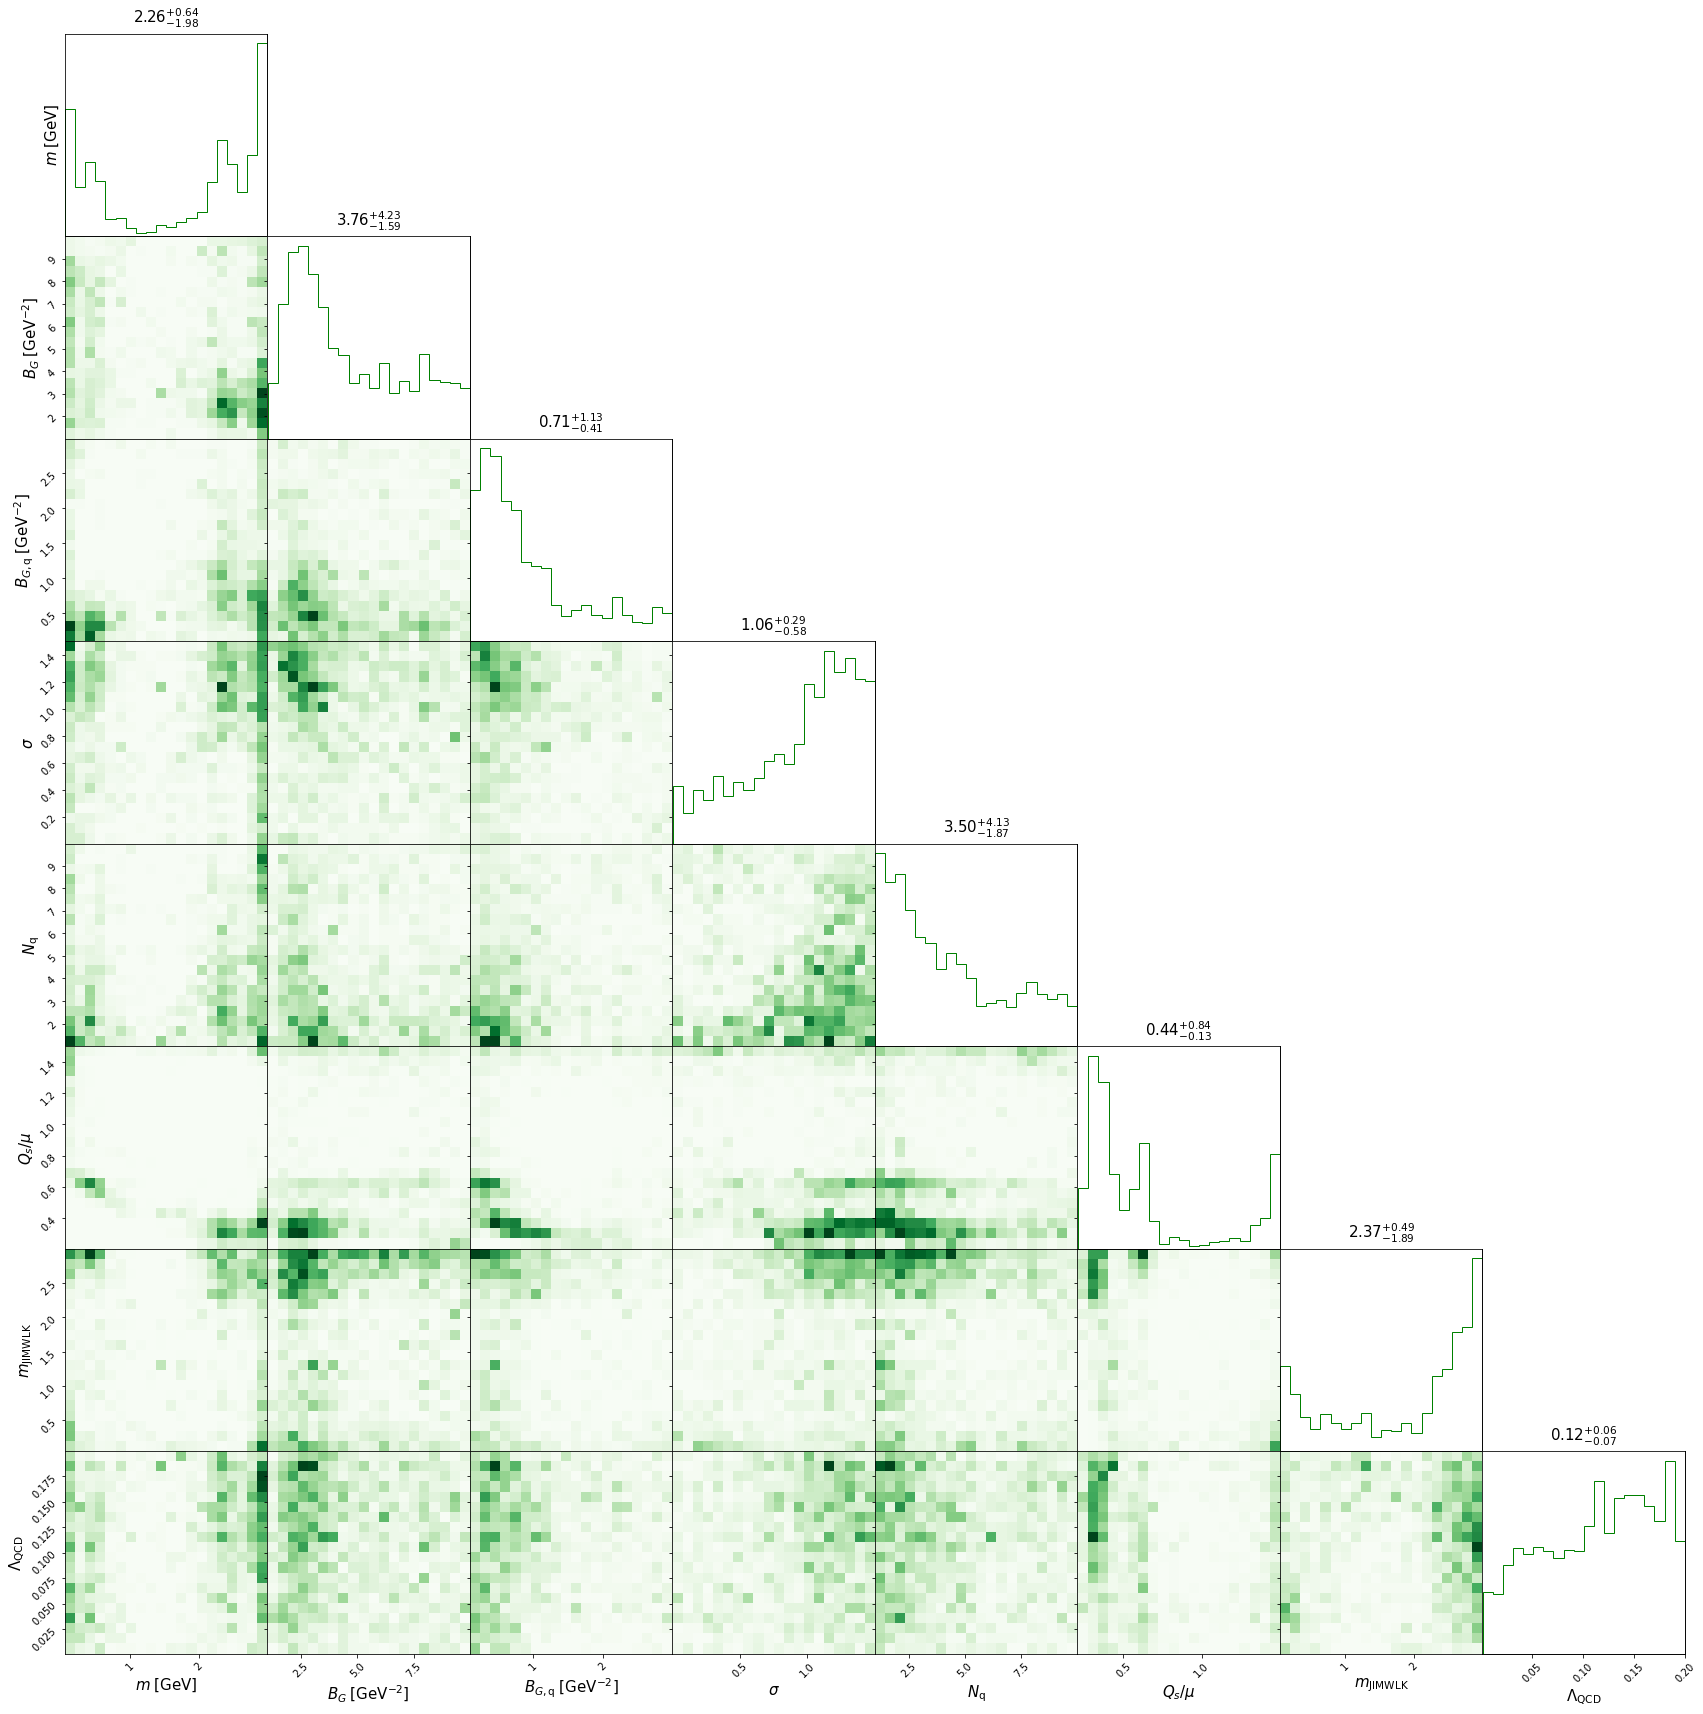

In [9]:
plot_corner_1dataset(len(PARAMETER_NAMES),RUN1_DATA['chain'],'corner_plot',real_parameters=None)

# Extract the MAP parameters using the GP emulator and the optimize function

In [10]:
# second method to find the maximum likelihood
from scipy import optimize
from src.mcmc import Chain

bound_min = [a[0] for a in prior_ranges]
bound_max = [b[1] for b in prior_ranges]
bounds = [(a,b) for (a,b) in zip(bound_min,bound_max)]

rslt = optimize.differential_evolution(lambda x: -mymcmc.log_likelihood(x.T), 
                                        bounds=bounds,
                                        maxiter=10000,
                                        disp=True,
                                        tol=1e-9,
                                        vectorized=True,
                                        )
print(rslt.x)

# print the MAP parameters to file
with open('MAP_parameters_JIMWLK.dat','w') as f:
    for i in range(len(rslt.x)):
        f.write(f'{PARAMETER_NAMES[i]}: {rslt.x[i]}\n')

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_differentialevolution.py:487: UserWarning: differential_evolution: the 'vectorized' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,


differential_evolution step 1: f(x)= 366.037895527783
differential_evolution step 2: f(x)= 365.57743735208874
differential_evolution step 3: f(x)= 364.5620935958366
differential_evolution step 4: f(x)= 364.5620935958366
differential_evolution step 5: f(x)= 364.5620935958366
differential_evolution step 6: f(x)= 364.5620935958366
differential_evolution step 7: f(x)= 363.37301514130877
differential_evolution step 8: f(x)= 363.37301514130877
differential_evolution step 9: f(x)= 363.37301514130877
differential_evolution step 10: f(x)= 361.46328851540034
differential_evolution step 11: f(x)= 361.46328851540034
differential_evolution step 12: f(x)= 361.46328851540034
differential_evolution step 13: f(x)= 361.46328851540034
differential_evolution step 14: f(x)= 361.46328851540034
differential_evolution step 15: f(x)= 361.46328851540034
differential_evolution step 16: f(x)= 361.46328851540034
differential_evolution step 17: f(x)= 360.9533991297702
differential_evolution step 18: f(x)= 360.95339